<a href="https://colab.research.google.com/github/EmilianoLS/Data-Science/blob/main/starbucks_segment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scikit-plot

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import json
import zipfile
import calendar

# Funciones de clusterizacion
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score

# Visualizacion de clusters
from yellowbrick.cluster import KElbowVisualizer

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [84]:
# Define a function to calculate and plot specified # of clusters
def kmeans_plot(df, clusters_number):
    '''
    Implement k-means clustering on dataset
    
    INPUT:
        dataset : dataframe. Dataset for k-means to fit.
        clusters_number : int. Number of clusters to form.
        end : int. Ending range of kmeans to test.
    OUTPUT:
        Cluster results and t-SNE visualisation of clusters.
    '''   
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(df)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = df.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], 
                    hue=cluster_labels, style=cluster_labels, palette="Set1")
    
    return df_new, cluster_labels

In [2]:
#!pip install -q kaggle
#!pip install -q kaggle-cli
#!mkdir -p ~/.kaggle
#!cp "/content/drive/MyDrive/.kaggle/kaggle.json" ~/.kaggle/
#!cat ~/.kaggle/kaggle.json 
#!chmod 600 ~/.kaggle/kaggle.json
# For competition datasets
#!kaggle competitions download -c instacart-market-basket-analysis -p '/content/drive/MyDrive/Colab Notebooks/datasets'

In [3]:
df_list = []
file_list = ['aisles.csv.zip', 'departments.csv.zip', 
             'order_products__train.csv.zip','order_products__prior.csv.zip',
             'orders.csv.zip','products.csv.zip']

for file_name in file_list:
  zf = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/datasets/' + file_name) 
  df_list.append(pd.read_csv(zf.open(file_name[:-4])))


aisles = df_list[0]
departments = df_list[1]
order_products_train = df_list[2]
order_products_prior = df_list[3]
orders = df_list[4]
products = df_list[5]

## EDA

### Orders

In [4]:
orders_subset = orders.loc[orders['eval_set'].isin(['prior','train'])].reset_index(drop = True)
orders_subset['order_dow_name'] = orders_subset['order_dow'].apply(lambda x: calendar.day_abbr[x])

In [5]:
orders_subset.head()

order_id  user_id  ... days_since_prior_order  order_dow_name
0   2539329        1  ...                    NaN             Wed
1   2398795        1  ...                   15.0             Thu
2    473747        1  ...                   21.0             Thu
3   2254736        1  ...                   29.0             Fri
4    431534        1  ...                   28.0             Fri

[5 rows x 8 columns]

In [6]:
orders_subset.shape

(3346083, 8)

In [7]:
orders_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3346083 entries, 0 to 3346082
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
 7   order_dow_name          object 
dtypes: float64(1), int64(5), object(2)
memory usage: 204.2+ MB


In [8]:
orders_subset.describe()

order_id       user_id  ...  order_hour_of_day  days_since_prior_order
count  3.346083e+06  3.346083e+06  ...       3.346083e+06            3.139874e+06
mean   1.710561e+06  1.029778e+05  ...       1.344887e+01            1.097229e+01
std    9.875758e+05  5.953534e+04  ...       4.226137e+00            9.121475e+00
min    1.000000e+00  1.000000e+00  ...       0.000000e+00            0.000000e+00
25%    8.552595e+05  5.139100e+04  ...       1.000000e+01            4.000000e+00
50%    1.710552e+06  1.026750e+05  ...       1.300000e+01            7.000000e+00
75%    2.565877e+06  1.543870e+05  ...       1.600000e+01            1.500000e+01
max    3.421083e+06  2.062090e+05  ...       2.300000e+01            3.000000e+01

[8 rows x 6 columns]

In [9]:
# Numero de usuarios unicos
print(f'Hay {orders_subset.user_id.nunique()} usuarios únicos y {orders_subset.shape[0]} ordenes')

Hay 206209 usuarios únicos y 3346083 ordenes


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


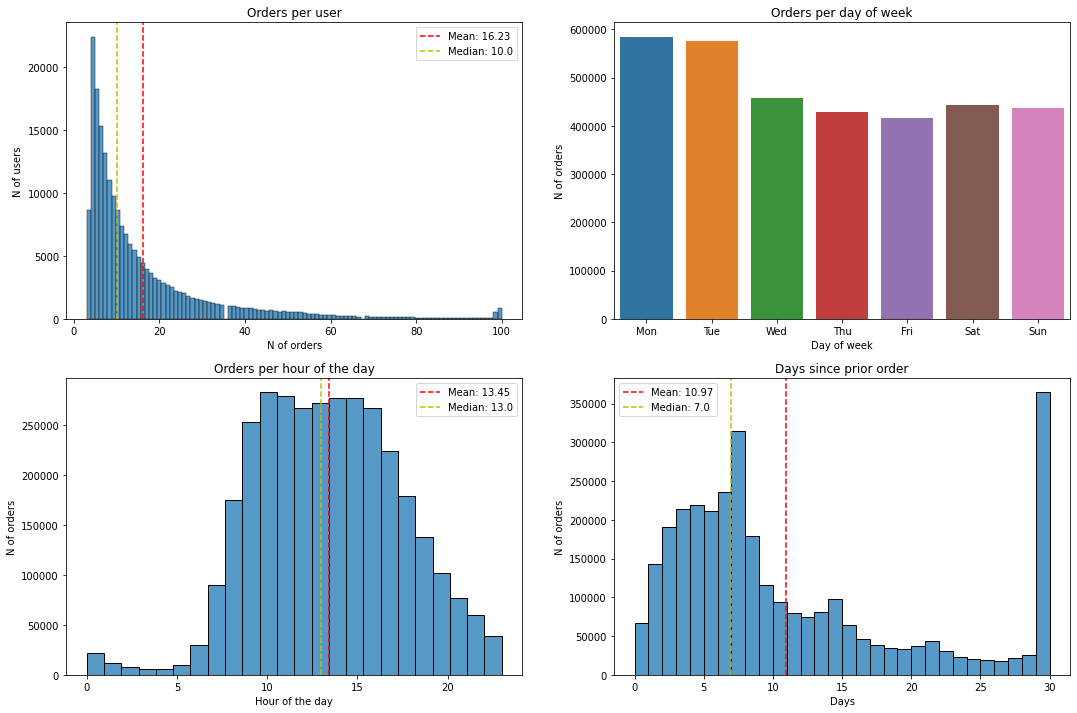

In [10]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (18, 12))

# Ordenes por usuario
sns.histplot(orders_subset.user_id.value_counts(), bins = 100, ax = ax[0,0])
media = np.mean(orders_subset.user_id.value_counts())
mediana = np.median(orders_subset.user_id.value_counts())
ax[0,0].axvline(media, linestyle = '--', color = 'r', label = 'Mean: ' + str(round(media, 2)))
ax[0,0].axvline(mediana, linestyle = '--', color = 'y', label = 'Median: ' + str(round(mediana, 2)))
ax[0,0].set_xlabel('N of orders')
ax[0,0].set_ylabel('N of users')
ax[0,0].set_title('Orders per user')
ax[0,0].legend()

# Ordenes por dia de la semana
sns.countplot(orders_subset.order_dow_name, order = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], ax = ax[0,1])
ax[0,1].set_xlabel('Day of week')
ax[0,1].set_ylabel('N of orders')
ax[0,1].set_title('Orders per day of week')

# Ordenes por hora del dia
sns.histplot(orders_subset.order_hour_of_day, bins = 24, ax = ax[1,0])
media = np.mean(orders_subset.order_hour_of_day)
mediana = np.median(orders_subset.order_hour_of_day)
ax[1,0].set_xlabel('Hour of the day')
ax[1,0].set_ylabel('N of orders')
ax[1,0].set_title('Orders per hour of the day')
ax[1,0].axvline(media, linestyle = '--', color = 'r', label = 'Mean: ' + str(round(media, 2)))
ax[1,0].axvline(mediana, linestyle = '--', color = 'y', label = 'Median: ' + str(round(mediana, 2)))
ax[1,0].legend()


# Dias desde la ultima orden
sns.histplot(orders_subset.days_since_prior_order, bins = 30, ax = ax[1,1])
media = np.mean(orders_subset.days_since_prior_order)
mediana = orders_subset.days_since_prior_order.median()
ax[1,1].set_xlabel('Days')
ax[1,1].set_ylabel('N of orders')
ax[1,1].set_title('Days since prior order')
ax[1,1].axvline(media, linestyle = '--', color = 'r', label = 'Mean: ' + str(round(media, 2)))
ax[1,1].axvline(mediana, linestyle = '--', color = 'y', label = 'Median: ' + str(round(mediana, 2)))
ax[1,1].legend()

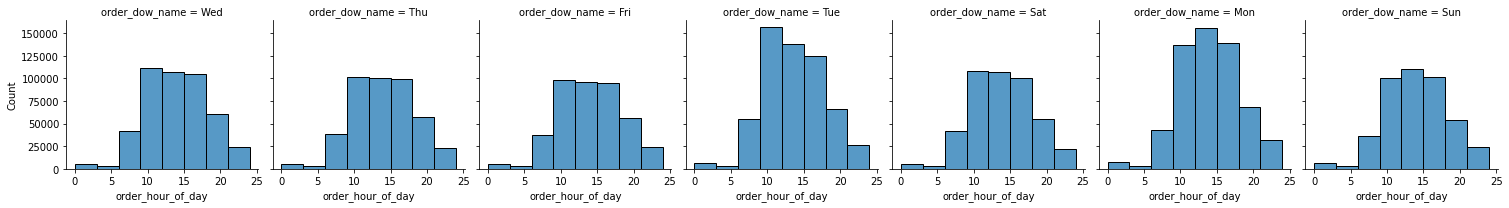

In [11]:
# Cantidad de ordenes por hora del dia, para cada dia de la semana
sns.displot(
    orders_subset, x = "order_hour_of_day", col = "order_dow_name",
    binwidth=3, height=3, facet_kws=dict(margin_titles=False),bins = 25
)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


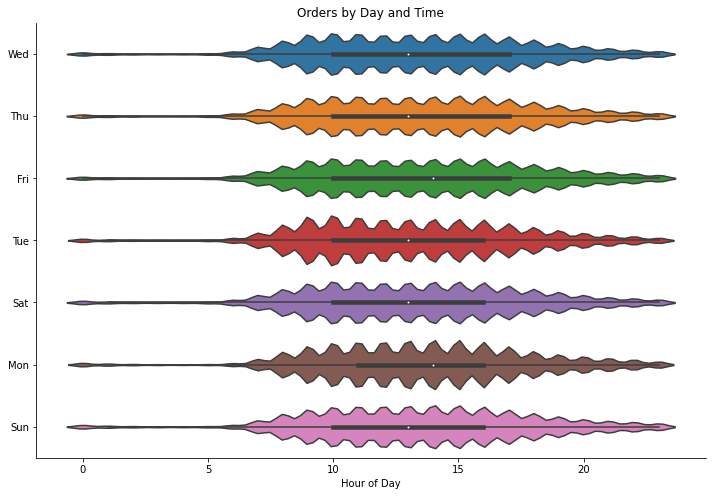

In [12]:
plt.figure(figsize=(12, 8))
sns.violinplot(orders_subset.order_hour_of_day, orders_subset.order_dow_name, orient='h')
plt.xlabel('Hour of Day')
plt.ylabel('')
plt.title('Orders by Day and Time')
sns.despine()

### Order Products

In [13]:
# Join both prior and train order_products

order_products = pd.concat([order_products_prior, order_products_train]).reset_index(drop = True)

Text(0.5, 1.0, 'Percentage of reorder')

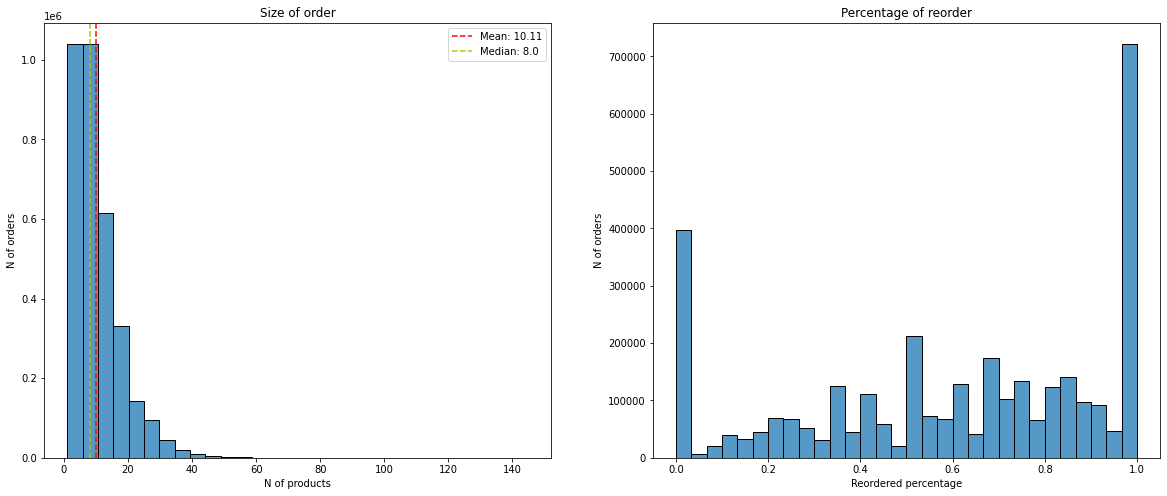

In [14]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))

# Numero de productos por orden
media = np.mean(order_products.order_id.value_counts())
mediana = np.median(order_products.order_id.value_counts())
sns.histplot(order_products.order_id.value_counts(), bins = 30, ax = ax[0])
ax[0].axvline(media, linestyle = '--', color = 'r', label = 'Mean: ' + str(round(media, 2)))
ax[0].axvline(mediana, linestyle = '--', color = 'y', label = 'Median: ' + str(round(mediana, 2)))
ax[0].set_xlabel('N of products')
ax[0].set_ylabel('N of orders')
ax[0].set_title('Size of order')
ax[0].legend()

# Tasa de productos reordenados por orden

sns.histplot(order_products.groupby('order_id')['reordered'].mean(), bins = 30, ax = ax[1])
ax[1].set_xlabel('Reordered percentage')
ax[1].set_ylabel('N of orders')
ax[1].set_title('Percentage of reorder')

In [15]:
# Describe sobre el numero de productos por ordenes
order_products.groupby('order_id').agg({'product_id':'count'}).describe()

product_id
count  3.346083e+06
mean   1.010707e+01
std    7.542326e+00
min    1.000000e+00
25%    5.000000e+00
50%    8.000000e+00
75%    1.400000e+01
max    1.450000e+02

In [16]:
# Describe sobre el porcentaje de re ordenacion
order_products.groupby('order_id').agg({'reordered':'mean'}).describe()

reordered
count  3.346083e+06
mean   5.988126e-01
std    3.367931e-01
min    0.000000e+00
25%    3.333333e-01
50%    6.666667e-01
75%    9.032258e-01
max    1.000000e+00

In [17]:
# Detalle de la cantidad de productos en las ordenes con una tasa de re ordenación del 100%

order_products_grouped_reorder = order_products.groupby('order_id').agg({'reordered':'mean','product_id':'count'})

In [18]:
order_products_grouped_reorder[order_products_grouped_reorder['reordered'] == 1.0]['product_id'].describe()

count    719207.000000
mean          5.749913
std           5.044118
min           1.000000
25%           2.000000
50%           4.000000
75%           8.000000
max         102.000000
Name: product_id, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


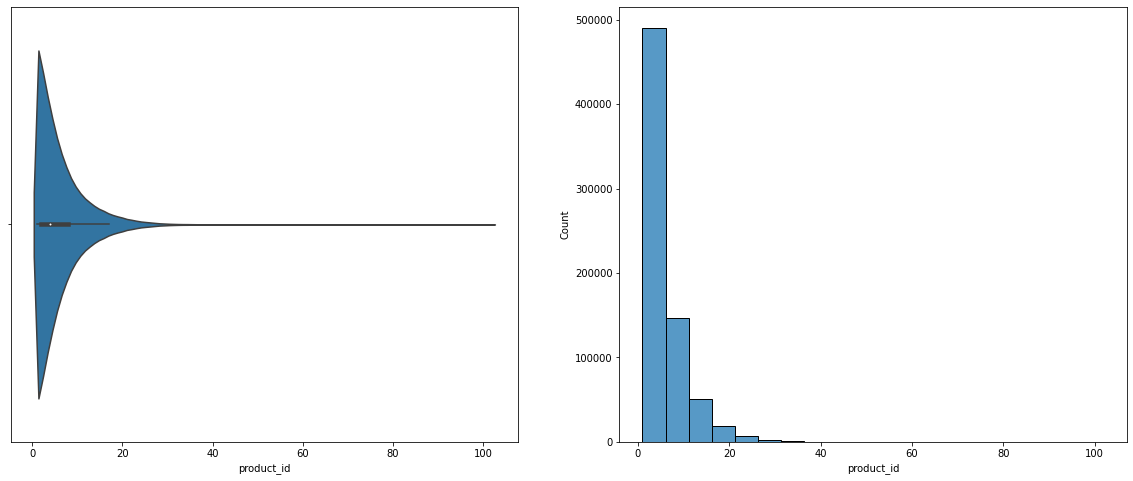

In [19]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
sns.violinplot(order_products_grouped_reorder[order_products_grouped_reorder['reordered'] == 1.0]['product_id'], ax = ax[0])
sns.histplot(order_products_grouped_reorder[order_products_grouped_reorder['reordered'] == 1.0]['product_id'], bins = 20, ax = ax[1])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


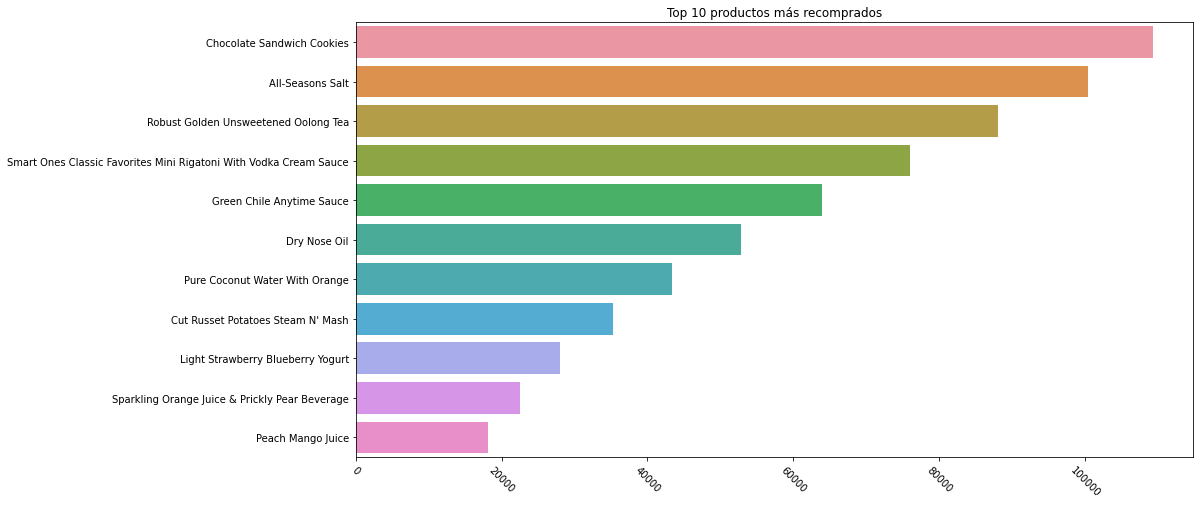

In [20]:
# Productos que suelen ser más recomprados 
top_products_reorder = pd.merge(order_products_grouped_reorder, products[['product_id','product_name']], how = 'left', on = 'product_id')

# Plot
plt.figure(figsize = (15,8))
plt.xticks(rotation = -45)
plt.title('Top 10 productos más recomprados')
names = top_products_reorder[top_products_reorder['reordered'] == 1.0]['product_name'].value_counts()[:11].index
orders = top_products_reorder[top_products_reorder['reordered'] == 1.0]['product_name'].value_counts()[:11].values
sns.barplot(orders, names)

In [21]:
# Tamaño de la orden para aquellas con una tasa de re ordenamiento menor al 100%
order_products_grouped_reorder[order_products_grouped_reorder['reordered'] < 1.0]['product_id'].describe()

count    2.626876e+06
mean     1.130001e+01
std      7.672981e+00
min      1.000000e+00
25%      6.000000e+00
50%      1.000000e+01
75%      1.500000e+01
max      1.450000e+02
Name: product_id, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


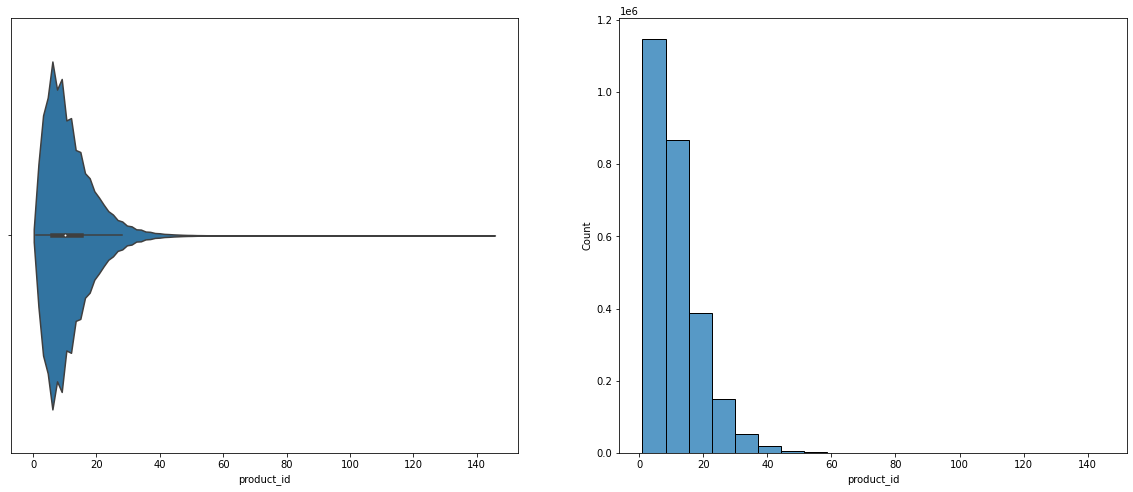

In [22]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
sns.violinplot(order_products_grouped_reorder[order_products_grouped_reorder['reordered'] < 1.0]['product_id'], ax = ax[0])
sns.histplot(order_products_grouped_reorder[order_products_grouped_reorder['reordered'] < 1.0]['product_id'], bins = 20, ax = ax[1])

In [23]:
# Obtengo el tamaño de las ordenes segun el dia de la semana

order_products_temp = pd.merge(order_products, orders_subset[['order_id','order_dow_name']], how = 'left', on = 'order_id')
order_products_temp = order_products_temp.groupby(['order_id','order_dow_name'], as_index = False).agg({'product_id':'count'})

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


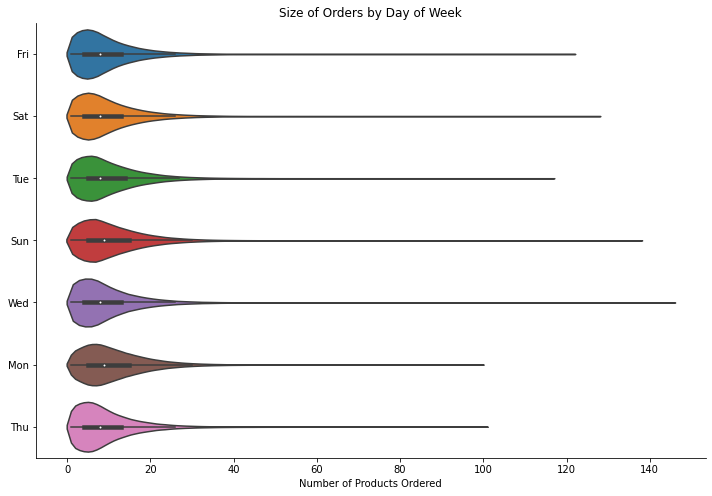

In [24]:
plt.figure(figsize=(12, 8))
sns.violinplot(order_products_temp.product_id, order_products_temp.order_dow_name, 
               orient='h')
plt.xlabel('Number of Products Ordered')
plt.ylabel('')
plt.title('Size of Orders by Day of Week')
sns.despine()

In [25]:
# Uno con la tabla de descripcion de productos
order_products = pd.merge(order_products, products[['product_id','product_name']], how = 'left', on = 'product_id')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


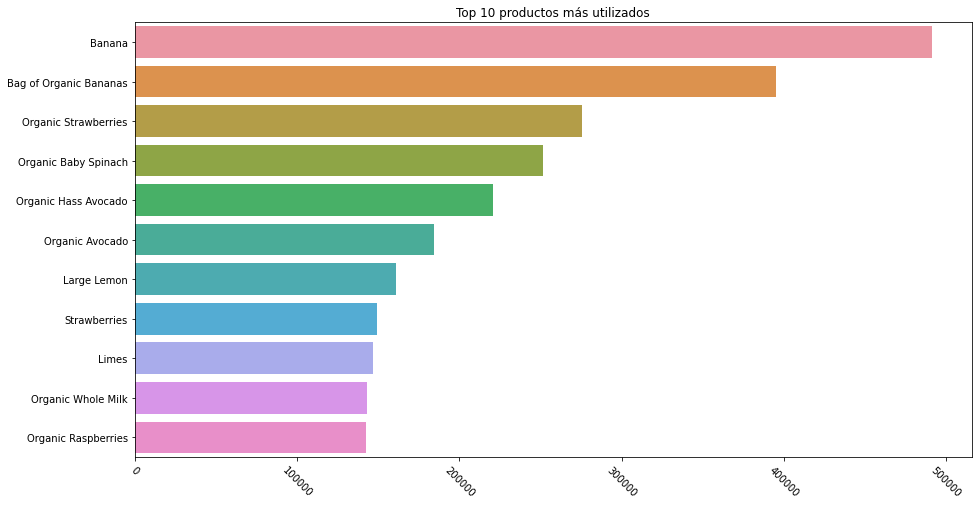

In [26]:
# 10 Productos más comunes
plt.figure(figsize = (15,8))
plt.xticks(rotation = -45)
plt.title('Top 10 productos más utilizados')
names = order_products.product_name.value_counts()[:11].index
orders = order_products.product_name.value_counts()[:11].values
sns.barplot(orders, names)

### Products

Text(0.5, 1.0, 'Products in departments')

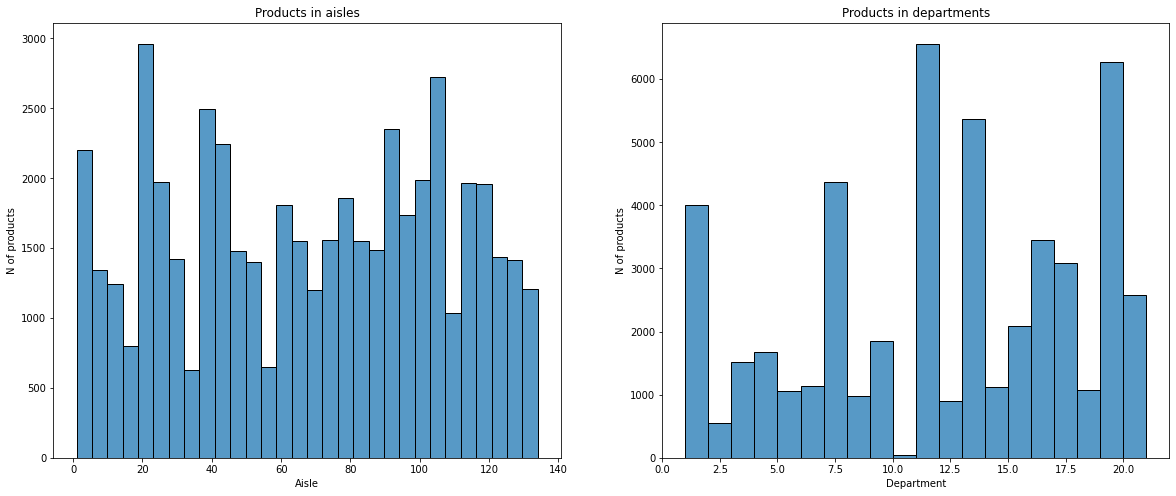

In [27]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))

# Numero de productos por aisle

sns.histplot(products.aisle_id, bins = 30, ax = ax[0])
ax[0].set_xlabel('Aisle')
ax[0].set_ylabel('N of products')
ax[0].set_title('Products in aisles')


# Tasa de productos reordenados por orden

sns.histplot(products.department_id, bins = 20, ax = ax[1])
ax[1].set_xlabel('Department')
ax[1].set_ylabel('N of products')
ax[1].set_title('Products in departments')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


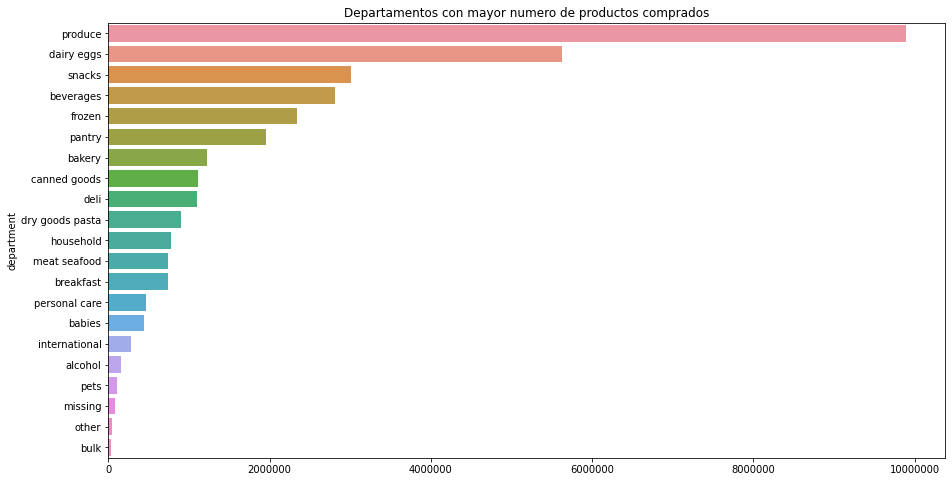

In [28]:
# Obtengo cantidad de productos por departamentos
# Mergeo los dataframes para conseguir las descripciones de los productos, asiles y departamentos
products_merged = pd.merge(products, order_products.drop(columns = ['product_name', 'add_to_cart_order'], axis = 1), on = 'product_id', how = 'left')
products_merged = pd.merge(products_merged, departments, on = 'department_id', how = 'left')
products_merged = pd.merge(products_merged, aisles, on = 'aisle_id', how = 'left')

# Calculo la cantidad total de productos por departamentos 
products_by_dep = products_merged.groupby(['department','product_name'], as_index = False).agg({'product_id':'count'})
products_by_dep = products_by_dep.groupby('department').agg({'product_id':'sum'})

# Plot
plt.figure(figsize = (15,8))
plt.ticklabel_format(style='plain', axis='x')
plt.title('Departamentos con mayor numero de productos comprados')
department = products_by_dep.sort_values(by = 'product_id', ascending = False).index
n_products = products_by_dep.sort_values(by = 'product_id', ascending = False)['product_id'].tolist()
sns.barplot(n_products, department)

## Customer Segmentation

### Feature Engineering

In [29]:
# Numero de productos por order id
prod_counts = order_products.groupby('order_id', as_index = False).agg({'product_id':'count'})
prod_counts.rename(columns = {'product_id':'num_products'}, inplace = True)

In [30]:
# Creo user data con información de cantidad de productos por orden
user_data = pd.merge(orders_subset, prod_counts, on = 'order_id', how = 'inner')

In [31]:
# Numero total de ordenes por usuario
num_orders = user_data.groupby('user_id', as_index = False).agg({'order_number':'max'})

In [32]:
# Flag para identificar si compra en dia pico (entre dia de la semana 0 o 1)
user_data['order_on_peak'] = np.where(user_data['order_dow'] <=1, 1, 0)

In [33]:
# Calculo el ratio al cual cada usuario ordena en días pico
peak_day_rate = round(user_data.groupby('user_id', as_index = False).agg({'order_on_peak':'mean'}), 3)

In [34]:
# Calculo la mediana para la hora del dia en que cada usuario realiza un pedido
median_hour = round(user_data.groupby('user_id', as_index = False).agg({'order_hour_of_day':'median'}), 3)

In [35]:
# Calculo ratio al cual los usuarios realizan pedidos durante horas picos 
# (10 y 16)

# Creo flag para detectar si el usuario realizó una compra durante hora pico
user_data['peak_time'] = np.where((user_data.order_hour_of_day >= 10) & 
                                  (user_data.order_hour_of_day <= 16), 1, 0)

# Calculo el ratio
peak_time_rate = round(user_data.groupby('user_id', as_index = False).agg({'peak_time':'mean'}), 3)

In [36]:
# Calculo la demora promedio entre pedidos por usuario
mean_lag = round(user_data.groupby('user_id', as_index = False).agg({'days_since_prior_order':'mean'}), 3)

In [37]:
# Calculo la cantidad de productos promedio comprados por usuario
mean_products = round(user_data.groupby('user_id', as_index = False).agg({'num_products':'mean'}), 0)

In [38]:
# Agrupo todas las features
new_features = [num_orders, peak_day_rate, median_hour, peak_time_rate, mean_lag, mean_products]

# Seteo el user_id como indice para facilitar el join. De todas formas no es un
# dato relevante al momento de clusterizar
for feature in new_features:
  feature.set_index('user_id', inplace = True)

# Concateno
features = pd.concat(new_features, axis=1)
features.head()

order_number  order_on_peak  ...  days_since_prior_order  num_products
user_id                               ...                                      
1                  11          0.273  ...                  19.000           6.0
2                  15          0.400  ...                  16.286          15.0
3                  12          0.667  ...                  12.091           7.0
4                   5          0.000  ...                  13.750           4.0
5                   5          0.600  ...                  11.500           9.0

[5 rows x 6 columns]

In [39]:
  # Reviso valores faltantes
  features.isna().sum()

order_number              0
order_on_peak             0
order_hour_of_day         0
peak_time                 0
days_since_prior_order    0
num_products              0
dtype: int64

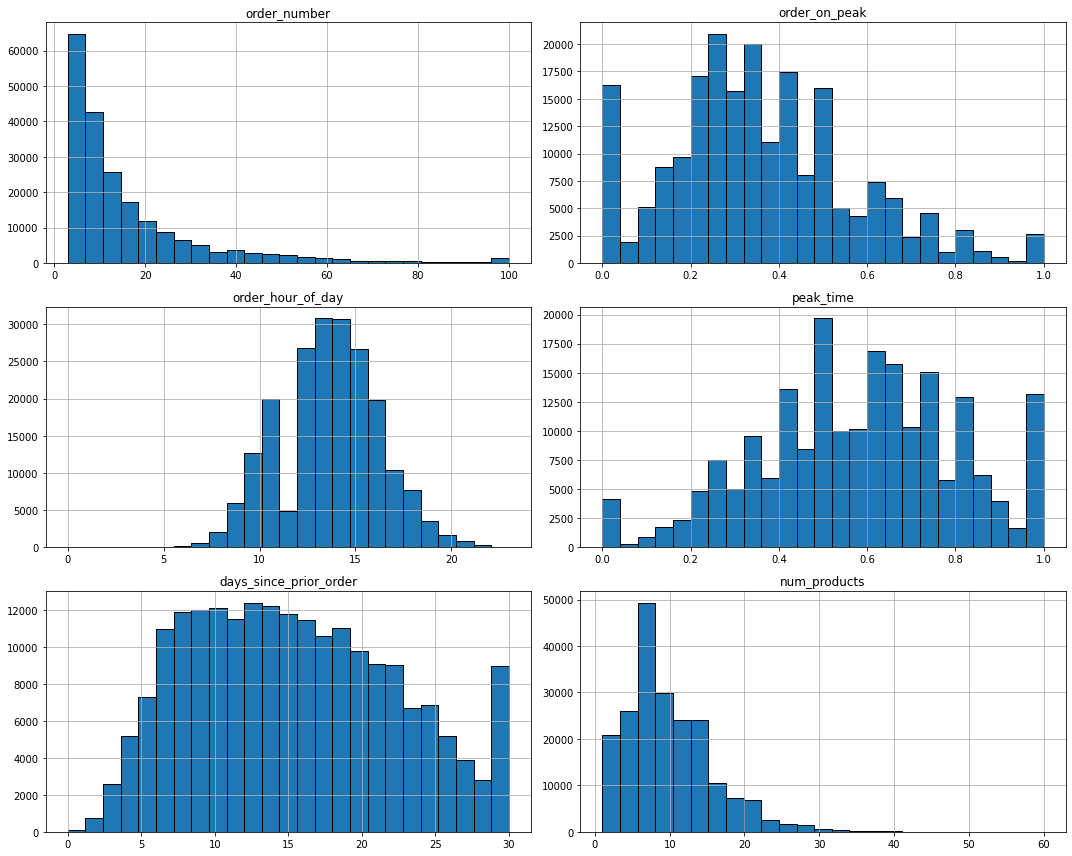

In [40]:
# Visualizo la distribucion de estas variables para asegurar que tengan una 
# distribución "normal"

features.hist(figsize=(15,12), bins = 25, ec = 'black')
plt.tight_layout()

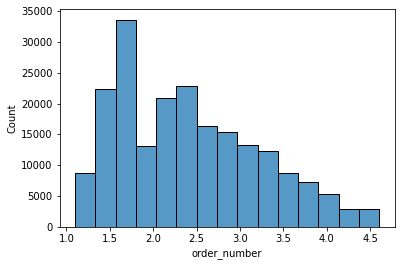

In [41]:
# Realizo una log transform sobre el numero de ordenes
features['order_number'] = np.log(features['order_number'])
sns.histplot(features['order_number'], bins = 15)

In [57]:
# Selecciono al azar 25k usuarios para segmentar
random_users = random.sample(features.index.tolist(), 25000)
subset_features = features.filter(random_users, axis = 0)

# Escalo las features
scaler = StandardScaler()
feat_scaled = scaler.fit_transform(subset_features)

# Convierto en dataframe 
feat_scaled = pd.DataFrame(feat_scaled)
feat_scaled.describe()

0             1  ...             4             5
count  2.500000e+04  2.500000e+04  ...  2.500000e+04  2.500000e+04
mean  -7.141665e-16 -5.430767e-17  ...  2.939515e-16  8.753442e-17
std    1.000020e+00  1.000020e+00  ...  1.000020e+00  1.000020e+00
min   -1.574605e+00 -1.674272e+00  ... -2.207012e+00 -1.530735e+00
25%   -7.427951e-01 -6.735211e-01  ... -8.207220e-01 -6.779009e-01
50%   -1.297799e-01 -1.023376e-01  ... -7.645352e-02 -1.662004e-01
75%    7.020300e-01  6.859901e-01  ...  7.382265e-01  5.160671e-01
max    2.633433e+00  3.046253e+00  ...  2.095118e+00  7.168175e+00

[8 rows x 6 columns]

### Buscando el K óptimo

#### Con todas las features

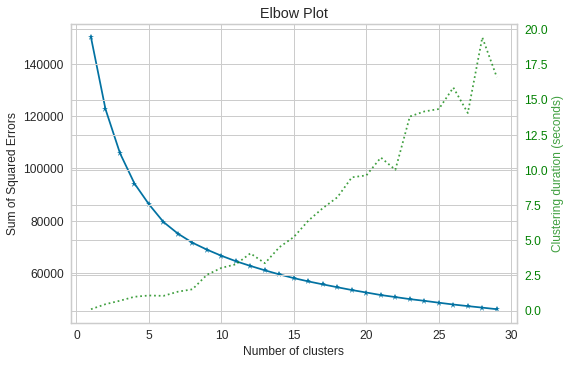

In [69]:
import scikitplot as skplt

kmeans = KMeans(random_state=1)
skplt.cluster.plot_elbow_curve(kmeans, X = feat_scaled, cluster_ranges=range(1, 30))

(              0         1         2         3         4         5  Cluster
 0     -0.397563 -0.494141  1.695413 -1.436265  0.866000 -1.019035        0
 1     -0.557807  0.350833  1.695413 -1.279648  1.210744  0.857201        0
 2     -0.742795  0.685990  0.922307 -0.348649  0.775798  1.027768        0
 3      0.969813  0.213938 -0.237351 -0.261640 -0.097821  0.004367        5
 4     -0.557807  1.021147  1.695413 -1.901765 -0.868619 -0.166200        0
 ...         ...       ...       ...       ...       ...       ...      ...
 24995 -0.961590  2.102148  0.149202  0.086397 -0.199351 -0.677901        2
 24996 -0.397563  2.456187 -0.237351  0.738967  0.579191 -0.336767        2
 24997 -0.961590  1.158043  0.922307  0.086397  1.593203  0.686634        2
 24998 -1.574605 -0.102338  0.149202  0.377878  0.445968  0.174933        1
 24999 -1.229373 -0.494141 -1.010457  1.826583  1.378097 -0.848468        1
 
 [25000 rows x 7 columns], array([0, 0, 0, ..., 2, 1, 1], dtype=int32))

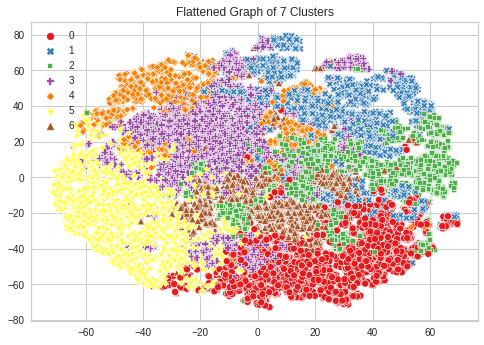

In [85]:
kmeans_plot(feat_scaled, 7)

(              0         1         2         3         4         5  Cluster
 0     -0.397563 -0.494141  1.695413 -1.436265  0.866000 -1.019035        2
 1     -0.557807  0.350833  1.695413 -1.279648  1.210744  0.857201        2
 2     -0.742795  0.685990  0.922307 -0.348649  0.775798  1.027768        2
 3      0.969813  0.213938 -0.237351 -0.261640 -0.097821  0.004367        0
 4     -0.557807  1.021147  1.695413 -1.901765 -0.868619 -0.166200        2
 ...         ...       ...       ...       ...       ...       ...      ...
 24995 -0.961590  2.102148  0.149202  0.086397 -0.199351 -0.677901        3
 24996 -0.397563  2.456187 -0.237351  0.738967  0.579191 -0.336767        3
 24997 -0.961590  1.158043  0.922307  0.086397  1.593203  0.686634        3
 24998 -1.574605 -0.102338  0.149202  0.377878  0.445968  0.174933        5
 24999 -1.229373 -0.494141 -1.010457  1.826583  1.378097 -0.848468        5
 
 [25000 rows x 7 columns], array([2, 2, 2, ..., 3, 5, 5], dtype=int32))

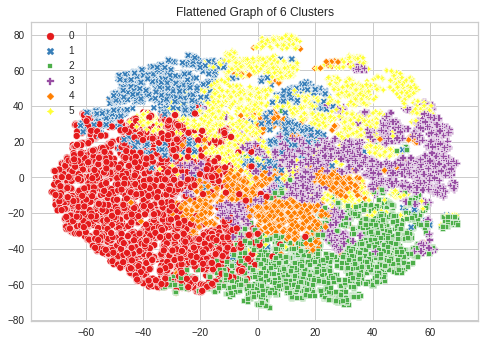

In [86]:
kmeans_plot(feat_scaled, 6)

(              0         1         2         3         4         5  Cluster
 0     -0.397563 -0.494141  1.695413 -1.436265  0.866000 -1.019035        0
 1     -0.557807  0.350833  1.695413 -1.279648  1.210744  0.857201        0
 2     -0.742795  0.685990  0.922307 -0.348649  0.775798  1.027768        0
 3      0.969813  0.213938 -0.237351 -0.261640 -0.097821  0.004367        4
 4     -0.557807  1.021147  1.695413 -1.901765 -0.868619 -0.166200        0
 ...         ...       ...       ...       ...       ...       ...      ...
 24995 -0.961590  2.102148  0.149202  0.086397 -0.199351 -0.677901        2
 24996 -0.397563  2.456187 -0.237351  0.738967  0.579191 -0.336767        2
 24997 -0.961590  1.158043  0.922307  0.086397  1.593203  0.686634        2
 24998 -1.574605 -0.102338  0.149202  0.377878  0.445968  0.174933        1
 24999 -1.229373 -0.494141 -1.010457  1.826583  1.378097 -0.848468        1
 
 [25000 rows x 7 columns], array([0, 0, 0, ..., 2, 1, 1], dtype=int32))

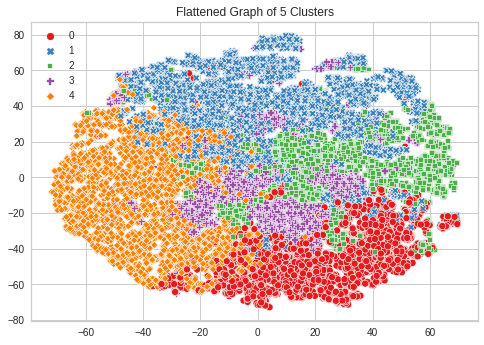

In [87]:
kmeans_plot(feat_scaled, 5)

#### Con features tipo RFM

In [80]:
# Select remaining features
features_dt = subset_features.loc[:, ['order_on_peak', 'order_hour_of_day', 'peak_time']]

# Scale and convert to DataFrame
scaler = StandardScaler()
feat_dt_scaled = scaler.fit_transform(features_dt)
feat_dt_scaled = pd.DataFrame(feat_dt_scaled)

In [108]:
features_dt.head()

order_on_peak  order_hour_of_day  peak_time
user_id                                             
21168            0.250               18.0      0.250
128640           0.429               18.0      0.286
8511             0.500               16.0      0.500
50326            0.400               13.0      0.520
179227           0.571               18.0      0.143

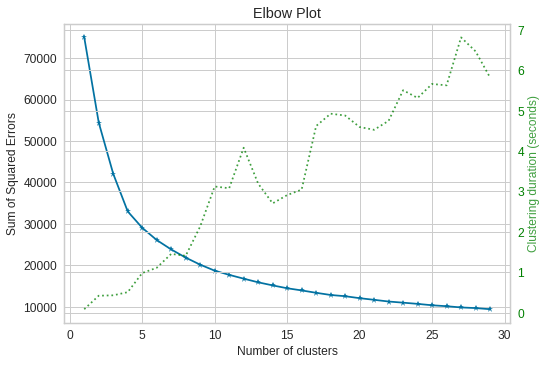

In [81]:
kmeans = KMeans(random_state=1)
skplt.cluster.plot_elbow_curve(kmeans, X = feat_dt_scaled, cluster_ranges=range(1, 30))

(              0         1         2  Cluster
 0     -0.494141  1.695413 -1.436265        0
 1      0.350833  1.695413 -1.279648        0
 2      0.685990  0.922307 -0.348649        0
 3      0.213938 -0.237351 -0.261640        3
 4      1.021147  1.695413 -1.901765        0
 ...         ...       ...       ...      ...
 24995  2.102148  0.149202  0.086397        2
 24996  2.456187 -0.237351  0.738967        2
 24997  1.158043  0.922307  0.086397        2
 24998 -0.102338  0.149202  0.377878        1
 24999 -0.494141 -1.010457  1.826583        1
 
 [25000 rows x 4 columns], array([0, 0, 0, ..., 2, 1, 1], dtype=int32))

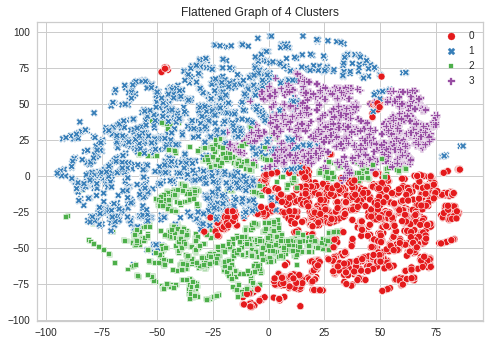

In [88]:
kmeans_plot(feat_dt_scaled, 4)

(              0         1         2  Cluster
 0     -0.494141  1.695413 -1.436265        0
 1      0.350833  1.695413 -1.279648        0
 2      0.685990  0.922307 -0.348649        0
 3      0.213938 -0.237351 -0.261640        1
 4      1.021147  1.695413 -1.901765        0
 ...         ...       ...       ...      ...
 24995  2.102148  0.149202  0.086397        2
 24996  2.456187 -0.237351  0.738967        2
 24997  1.158043  0.922307  0.086397        2
 24998 -0.102338  0.149202  0.377878        1
 24999 -0.494141 -1.010457  1.826583        1
 
 [25000 rows x 4 columns], array([0, 0, 0, ..., 2, 1, 1], dtype=int32))

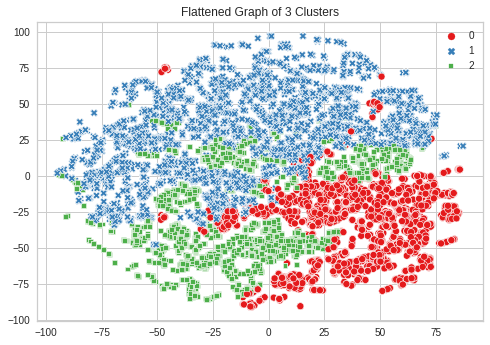

In [89]:
kmeans_plot(feat_dt_scaled, 3)

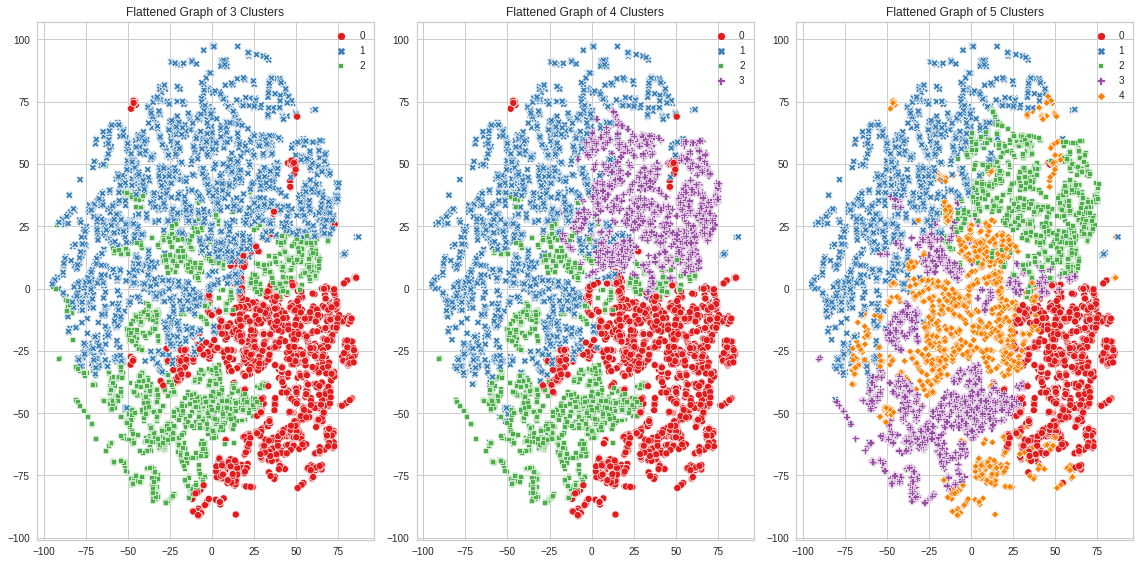

In [94]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
k3_small = kmeans_plot(feat_dt_scaled, 3)

plt.subplot(1, 3, 2)
k4_small = kmeans_plot(feat_dt_scaled, 4)

plt.subplot(1, 3, 3)
k5_small = kmeans_plot(feat_dt_scaled, 5)

plt.tight_layout()
plt.show()

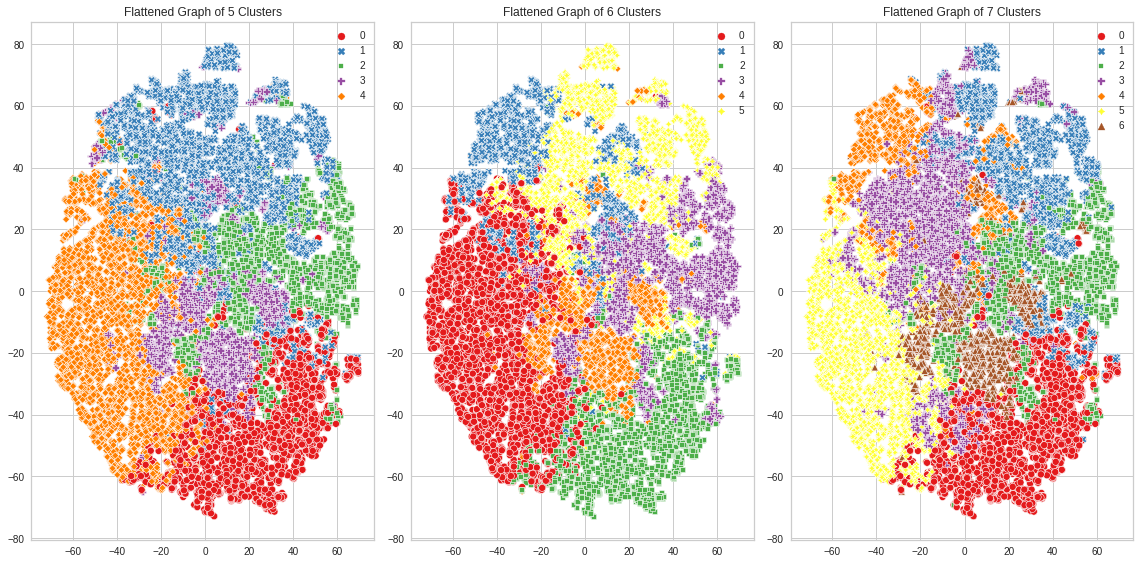

In [92]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
k3 = kmeans_plot(feat_scaled, 5)

plt.subplot(1, 3, 2)
k4 = kmeans_plot(feat_scaled, 6)

plt.subplot(1, 3, 3)
k5 = kmeans_plot(feat_scaled, 7)

plt.tight_layout()
plt.show()

## Studying clusters

### Features RFM - 4 Clusters

In [110]:
reduced_df_cluster = features_dt.copy()
reduced_df_cluster['cluster'] = k4_small[1]
reduced_df_cluster.head()

order_on_peak  order_hour_of_day  peak_time  cluster
user_id                                                      
21168            0.250               18.0      0.250        0
128640           0.429               18.0      0.286        0
8511             0.500               16.0      0.500        0
50326            0.400               13.0      0.520        3
179227           0.571               18.0      0.143        0

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Q de usuarios por cluster')

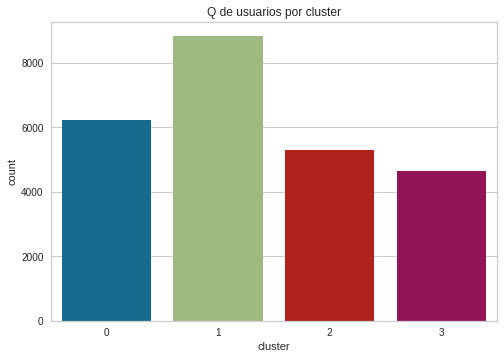

In [156]:
sns.countplot(reduced_df_cluster.cluster)
plt.title('Q de usuarios por cluster')

In [118]:
centroids_small = reduced_df_cluster.groupby('cluster', as_index = False).mean()

In [164]:
test = k4_small[0].groupby('Cluster').mean()

In [169]:
centroids_small

cluster  order_on_peak  order_hour_of_day  peak_time
0        0       0.329897          16.650328   0.358167
1        1       0.231255          13.234239   0.753764
2        2       0.627923          13.346794   0.696044
3        3       0.311645          10.553074   0.415962

Text(0.5, 1.0, 'Comparación de clusters (menos hora del día)')

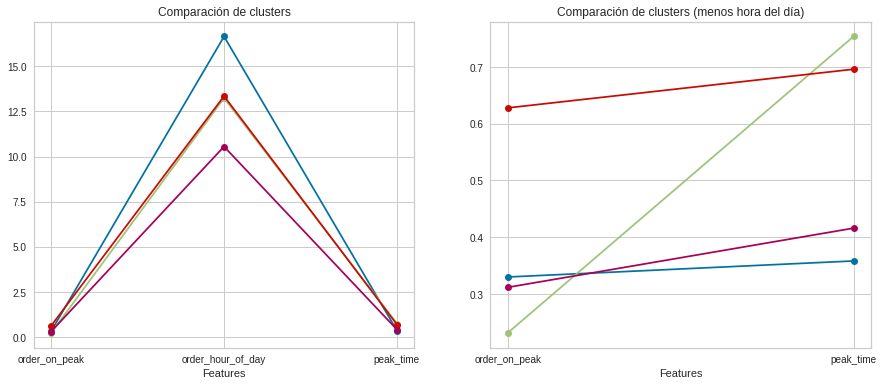

In [149]:
fig, ax = plt.subplots(1,2, figsize = (15, 6))
for i in range(len(centroids_small)):
  ax[0].plot(centroids_small.columns[1:],centroids_small.iloc[i, 1:].values, '-o')
  ax[1].plot(centroids_small.columns[[1,3]], centroids_small.iloc[i, [1,3]], '-o')

ax[0].set_xlabel('Features')
ax[0].set_title('Comparación de clusters')
ax[1].set_xlabel('Features')
ax[1].set_title('Comparación de clusters (menos hora del día)')


### All features - 5 Clusters

In [154]:
df_cluster = subset_features.copy()
df_cluster['cluster'] = k3[1]
df_cluster.head()

order_number  order_on_peak  ...  num_products  cluster
user_id                               ...                       
21168        2.079442          0.250  ...           4.0        0
128640       1.945910          0.429  ...          15.0        0
8511         1.791759          0.500  ...          16.0        0
50326        3.218876          0.400  ...          10.0        4
179227       1.945910          0.571  ...           9.0        0

[5 rows x 7 columns]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Q de usuarios por cluster')

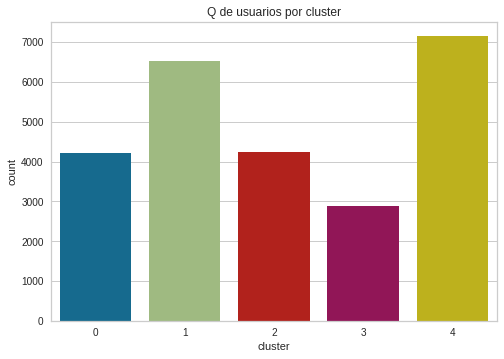

In [157]:
sns.countplot(df_cluster.cluster)
plt.title('Q de usuarios por cluster')

In [158]:
centroids = df_cluster.groupby('cluster', as_index = False).mean()

Text(0.5, 1.0, 'Comparación de clusters (menos hora del día)')

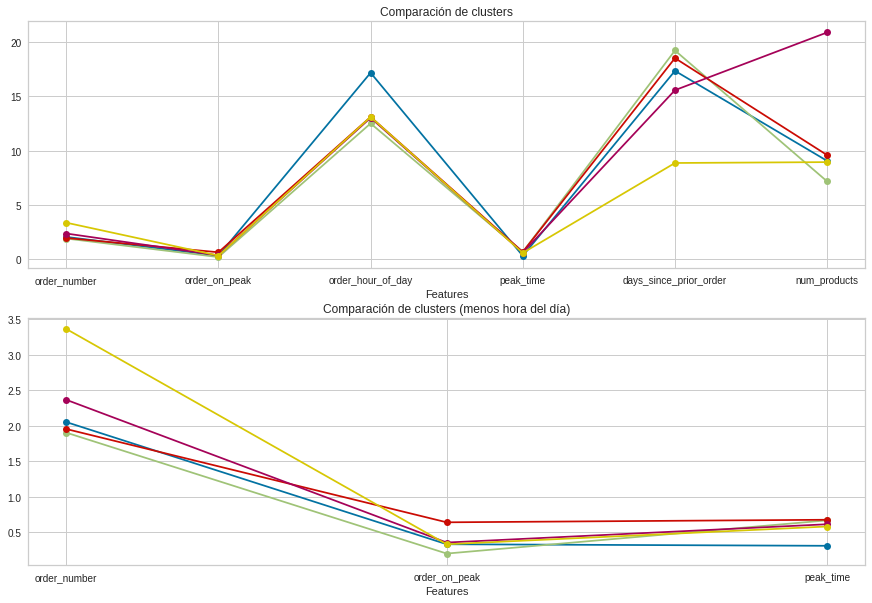

In [171]:
fig, ax = plt.subplots(2,1, figsize = (15, 10))
for i in range(len(centroids)):
  ax[0].plot(centroids.columns[1:],centroids.iloc[i, 1:].values, '-o')
  ax[1].plot(centroids.columns[[1,2,4]], centroids.iloc[i, [1,2,4]], '-o')

ax[0].set_xlabel('Features')
ax[0].set_title('Comparación de clusters')
ax[1].set_xlabel('Features')
ax[1].set_title('Comparación de clusters (menos hora del día)')
